In [75]:
import time
import numpy as np
import pandas as pd
import cvxpy as cp
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from notebook_utils.utils import * 
from pycss.utils import *
from pycss.CSS import * 
from pycss.subset_selection import complement 
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r
from rpy2.robjects.vectors import StrVector

In [208]:
def avg_R2(Sigma, S, standardized=True):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    resid_var = np.diag(Sigma_R)[S_comp]
    if standardized:
        return 1 - np.mean(np.diag(Sigma_R)[S_comp])
    else:
        var = np.diag(Sigma)[S_comp]
        return np.mean((var - resid_var)/var)

In [203]:
standardize = True

T = pd.read_csv("../data/topic_exposure.csv").to_numpy()[:, 1:].astype(float)
D = pd.read_csv("../data/specific_variance.csv").to_numpy()[:, 1:].astype(float)
X = pd.read_csv("../data/factor_exposure.csv").to_numpy()[:, 1:].astype(float)
F = pd.read_csv("../data/factor_covariance.csv").to_numpy()[:, 1:].astype(float)

V = X @ F @ X.T + np.diag(np.squeeze(D))
Sigma = T.T @ V @ T

p = Sigma.shape[0]

if standardize:
    Sigma = standardize_cov(Sigma)

eigs, vecs = np.linalg.eig(Sigma)
wh = eigs > 0
eigs = np.real(eigs[wh])
vecs = np.real(vecs[:, wh])
X = np.real(np.sqrt(p) * np.sqrt(eigs)[:, None] * vecs.T)
print(np.allclose(1/p * X.T @ X, Sigma))

True


In [110]:
n2r.activate()
glmnet = rpackages.importr('glmnet')
base = rpackages.importr('base')

In [158]:
p_max = 30 
num_inits=50

### Random

In [172]:
css_random_var_explained = np.zeros((p_max, num_inits))

for i in range(1, p_max + 1):
    for j in range(num_inits):
        S = np.random.choice(np.arange(p), size=i)
        css_random_var_explained[i-1, j] = avg_R2(Sigma, S)


In [181]:
random_df = pd.DataFrame({'Number of Principal Components/Variables': np.array([ num_inits*[i] for i in range(1, p_max+1) ]).flatten() , 'Average R^2': css_random_var_explained.flatten()  } ) 

In [190]:
random_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': np.max(css_random_var_explained, axis=1)  } ) 

### Group Lasso

In [200]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, X, standardize=False, intercept=False, family="mgaussian", alpha=1, dfmax=30)
    
len_dfs = len(fit['df'])
gl_coeff = fit['beta']['y1']
group_lasso_Ss = []
for i in range(len_dfs):
    group_lasso_Ss.append(np.squeeze(np.argwhere(base.as_matrix(gl_coeff)[:, i] != 0)))

dfs = fit['df'][1:]
group_lasso_Ss = group_lasso_Ss[1:]
for i in range(len(group_lasso_Ss)):
    if len(group_lasso_Ss[i].shape) == 0:
        group_lasso_Ss[i] = np.array([group_lasso_Ss[i]])

num_selected = []
css_group_lasso_var_explained = []
for i in range(len(fit['df'])):
    df = fit['df'][i]
    if df > 0 and df <= p_max and df not in num_selected:
        num_selected.append(df)
        css_group_lasso_var_explained.append(avg_R2(Sigma, group_lasso_Ss[i]))
            

In [201]:
group_lasso_df = pd.DataFrame({'Number of Principal Components/Variables': num_selected , 'Average R^2': css_group_lasso_var_explained})

In [206]:
for S in group_lasso_Ss:
    if len(S) == 2:
        print(S)

[152 166]
[152 166]
[152 166]


### Greedy

In [119]:
eigs = np.sort(eigs)[::-1]

css_greedy_var_explained = np.zeros(p_max)
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
for i in range(1, p_max + 1):
    css_greedy_var_explained[i - 1] =  avg_R2(Sigma, css.S[:i]) 


In [134]:
greedy_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': css_greedy_var_explained })

### Swapping

In [142]:

css_swap_var_explained = np.zeros((p_max, num_inits))
for i in tqdm(range(1, p_max + 1)):
    for j in range(num_inits):
        invertible = False
        while not invertible:
            try:
                css.select_subset_from_cov(Sigma, k=i, method='swap')
                invertible=True 
            except: 
                pass 
        css_swap_var_explained[i-1, j] = avg_R2(Sigma, css.S)

  0%|          | 0/30 [00:00<?, ?it/s]

In [180]:
swap_df = pd.DataFrame({'Number of Principal Components/Variables': np.array([ num_inits*[i] for i in range(1, p_max+1) ]).flatten() , 'Average R^2': css_swap_var_explained.flatten()  } ) 

In [192]:
swap_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1) , 'Average R^2': np.max(css_swap_var_explained, axis=1)  } ) 

### PCA

In [144]:
pca_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': [np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)] })

### Plot

/Users/anavsood/mambaforge/envs/css/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


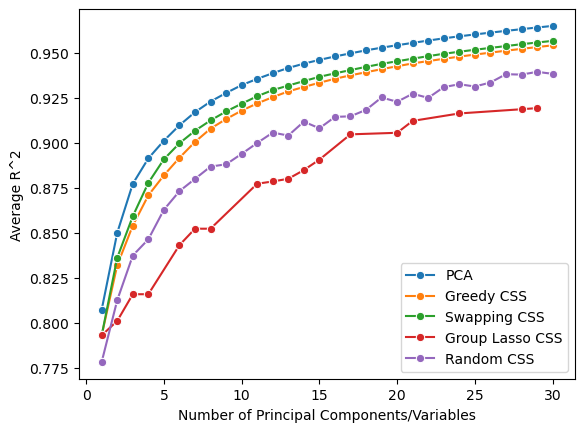

In [207]:
sns.lineplot(data=pca_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='PCA')

sns.lineplot(data=greedy_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Greedy CSS')

sns.lineplot(data=swap_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Swapping CSS')

sns.lineplot(data=group_lasso_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Group Lasso CSS')

sns.lineplot(data=random_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Random CSS')

plt.savefig("../figures/blackrock_results.pdf")

/Users/anavsood/mambaforge/envs/css/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


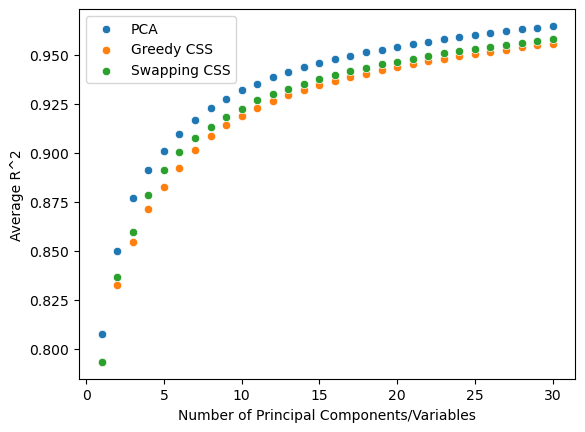

In [53]:
sns.scatterplot(x=np.arange(1, p_max + 1), y=[np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)], label='PCA').set(xlabel="Number of Principal Components/Variables", ylabel="Average R^2" )
sns.scatterplot(x=np.arange(1, p_max + 1), y=css_greedy_var_explained, label='Greedy CSS')
sns.scatterplot(x=np.arange(1, p_max + 1), y=css_swap_var_explained, label='Swapping CSS')

plt.savefig("../figures/blackrock_results.pdf")

In [44]:
print(css_greedy_var_explained)
print(css_swap_var_explained)

[0.7934445  0.83252599 0.8546137  0.87148977 0.88269912 0.89250351
 0.90136511 0.90877926 0.91415754 0.9188751  0.92293612 0.92644305
 0.92968578 0.93218311 0.93458444 0.93680345 0.93877498 0.94052971
 0.94225815 0.94391974 0.94552264 0.94685809 0.94814606 0.94938765
 0.9505486  0.95165954 0.95276112 0.95380683 0.95482028 0.95580765]
[0.7934445  0.83667549 0.85977817 0.87841295 0.89154404 0.90048168
 0.90750973 0.9132941  0.91831734 0.92265138 0.92686026 0.93029303
 0.93286086 0.93538281 0.93780586 0.93975566 0.94162754 0.94343019
 0.94513622 0.94661481 0.94808736 0.94950522 0.95086619 0.95201086
 0.95313978 0.95420381 0.95524576 0.95630403 0.95725886 0.9581948 ]


Compare greedy runtime to naive

In [3]:
tol=1e-10
p_max = 30

css = CSS()
start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
end = time.time()
efficient_time = end - start

start = time.time()
S = []
for i in tqdm(range(p_max)):
    options = complement(p, S)
    best_val = np.inf
    best_j = np.nan
    for j in options:
        option_val = np.mean(np.diag(regress_off(Sigma, S + [j])))
        if option_val < best_val:
            best_val = option_val
            best_j = j
    S.append(best_j)
end = time.time()
naive_time = end - start

print(naive_time/efficient_time)

  0%|          | 0/30 [00:00<?, ?it/s]

3849.2163889899357


Compare swapping runtime to naive

In [5]:
p_max = 30

N = 100

start = time.time()
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='swap')
end = time.time()
# time to select entire subset
whole_time = end - start 

start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='swap', S_init=css.S)
end = time.time()
# time to efficiently verify a local optimum is a local optimum
efficient_time = end - start

start = time.time()
S = css.S.copy()
for i in range(len(S)):
    current_val = np.mean(np.diag(regress_off(Sigma, S)))
    options = np.delete(np.arange(p), S)
    best = np.inf 
    best_S_option = np.nan
    for j in options:
        S_option = S.copy()
        S_option[i] = j
        option_val = np.mean(np.diag(regress_off(Sigma, S_option)))
        if option_val < best:
            best = option_val
            best_S_option = S_option
    if best < current_val:
        S = best_S_option.copy()
    break
end = time.time()
# time to naively verify a local optimum is a local optimum
naive_time = (end - start) * p_max

In [6]:
print(whole_time)
print(naive_time/efficient_time)

0.4303879737854004
5527.618619755847


In [31]:
# redefine swapping selection so that it returns the number of iterations it takes  
def swapping_subset_selection(Sigma, 
                              k,
                              objective,
                              max_iter=100,
                              S_init=None,
                              tol=TOL,
                              flag_colinearity=False):

    """
    Given a covariance `Sigma`, a subset size `k`, and an objective function `objective`
    returns the subset of variables `k` which minimize the objective selected by a gradient descent
    like iterative swapping algorithm. 

    Parameters
	----------
	Sigma : np.array
	    A `(p, p)`-shaped covariance matrix. 
    k : int
        Size of subset to search for.
    objective : Callable[np.array, bool, np.float]
        A python function which defines the objective. On each iteration the variable which 
        minimizes objective will be selected.
    max_iter : int, default=`100`
        Maximum number of iterations to run the swapping algorithm. If algorithm has not 
        converged within `max_iter` iterations, the algorithm will terminate and provide 
        results in its current state. In this case `converged` will be `False.
    S_init : np.array, default=`None`
        Intial subset to start the algorithm with. If not included, an initial subset is 
        selected uniformly randomly.  
    tol : float, default=`TOL`
        Tolerance at which point we consider a variable to have zero variance.
    flag_colinearity : bool, default=`True`
        Whether or not to flag colinearity issues and terminate upon their happening. 
	
    Returns 
	-------
	S : np.array
        The selected subset, in order it was selected.
    Sigma_R : np.array
        The `(p, p)`-shaped residual covariance matrix resulting from regressing the selected subset
        out of all the varibles (including themselves). 
    S_init : np.array
        The inital subset that the algorithm starts with.
    converged : bool
        Whether the algorithm has converged. If `converged` is `False` and the `errors` list is non-empty 
        then `S` and `Sigma_R` must be `None`. 
    errors : List[ValueError]
         List of ValueError objects detailing what the colinearity issues are. 
	"""

    converged = False
    p = Sigma.shape[0]
    d = p-k
    idx_order = np.arange(p)
    
    if S_init is None:
        S_init = np.random.choice(idx_order, k, replace=False)
    elif len(S_init) != k:
        raise ValueError("Initial subset must be of length k.")
    
    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma 
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order)
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = is_invertible(Sigma_S) 
    
    if not invertible:
        return None, None, S_init, converged, populate_colinearity_errors(S)
    
    regress_off_in_place(Sigma_R, np.arange(d, p))
    zero_idxs = np.where(np.diag(Sigma_R)[:d] <= tol)[0]
    num_zero_idxs = len(zero_idxs)
    
    if flag_colinearity and num_zero_idxs > 0:
        return None, None, S_init, converged, populate_colinearity_errors(S, responses=idx_order[zero_idxs])

    # number of completed iterations
    N = 0
    # counter of how many consecutive times a selected variable was not swapped
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    break_flag = False 

    while N < max_iter and (not break_flag):
        for i in range(k):
            S_0 = S[0]
            # Remove first variable from selected subset 
            T = S[1:]

            # Update cholesky after removing first variable from subset 
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L) 

            # Update residual covariance after removing first variable from subset
            v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
            reordered_v = v[idx_order]
            Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]

            # Swap first variable from subset to to top of residual matrix 
            swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)  
        
            # If not flag_colinearity, find indices of variables with zero variance
            if not flag_colinearity:
                zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= tol)[0]
                num_zero_idxs = len(zero_idxs)
                # In residual matrix, swap variables with zero indices to right above currently selected subset (of size k-1)
                swap_in_place(Sigma_R, zero_idxs, np.arange(d + 1 - num_zero_idxs, d + 1), idx_order=idx_order)
            else:
                num_zero_idxs = 0
        
            # update num_active
            num_active = d + 1 - num_zero_idxs 

            # compute objectives and for active variables and find minimizers
            obj_vals, colinearity_error_idxs = objective(Sigma_R[:num_active, :num_active], flag_colinearity=flag_colinearity, tol=tol)

            if len(colinearity_error_idxs[0]) > 0:
                return None, None, S_init, converged, populate_colinearity_errors(S[:i], 
                                                                                  idx_order[colinearity_error_idxs[0]], 
                                                                                  idx_order[colinearity_error_idxs[1]])
        
            choices = np.flatnonzero(obj_vals == obj_vals.min())

            # if removed variable is a choice, select it, otherwise select a random choice
            if 0 in choices:
                not_replaced += 1
                j_star = 0 
            else:
                not_replaced = 0
                j_star = np.random.choice(choices)

            # Add new choice as the last variable in selected subset
            S_new = idx_order[j_star]
            S[:k-1] = S[1:]
            S[k-1] = S_new
            # Update cholesky after adding new choice as last variable in selected subset 
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])
            # In residual covariance, regress selected variable off the remaining
            #regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star) #alternative option
            regress_one_off_in_place(Sigma_R[:num_active, :num_active], j_star)
            # In residual covariance swap new choice to top of selected subset and then permute selected subset
            # so the new choice is at the bottom, reflecting S
            swap_in_place(Sigma_R, np.array([j_star]), np.array([d]), idx_order=idx_order)
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)
        
            if not_replaced == k:
                converged=True
                break_flag=True
                break

        N += 1

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))
    return N-1, S, Sigma_R, S_init, converged, []

In [33]:
B = 100
iters = []
for i in tqdm(range(B)):
    try:
        N, _, _, _, _, _ = swapping_subset_selection(Sigma, p_max, css_objective)
        iters.append(N)
    except:
        pass

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3.,  0., 45.,  0.,  0., 31.,  0., 15.,  0.,  2.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <BarContainer object of 10 artists>)

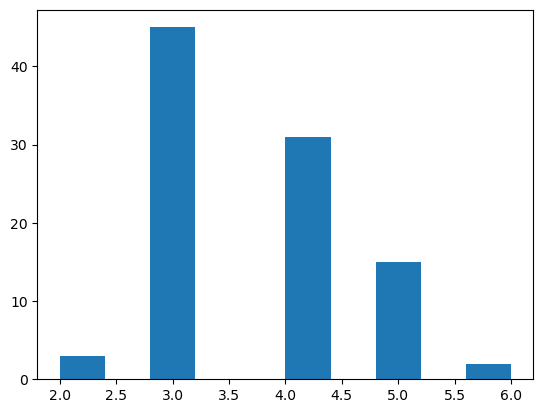

In [34]:
plt.hist(iters)

In [7]:
print(naive_time * np.median(iters))
print(naive_time * np.mean(iters))

2750.4223251342773
2562.893530238758
